In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocess_data(data):
    """ok"""
    grid = data[0, :]
    left_edges = grid[:-1]
    right_edges = grid[1:]
    return right_edges - left_edges

class Matrix:
    """ok"""
    def __init__(self, intervals):
        self.intervals = intervals
    def get(self, i, j):
        if i >= len(self.intervals) - 1 or j >= len(self.intervals) - 1:
            raise IndexError("index ({}, {}) is out of range".format(i, j))
        elif i == j:
            return 2.0
        elif abs(i-j) > 1:
            return 0
        else:
            a1 = max(i, j)
            if j > i:
                return self.intervals[i+1]/(self.intervals[i+1] + self.intervals[i])
            if j < i:
                return self.intervals[i]/(self.intervals[i+1] + self.intervals[i])         

class Column:
    """ok"""
    def __init__(self, values, intervals):
        self.values = values
        self.intervals = intervals
    def get(self, i):
        if i >= len(self.intervals) - 1:
            raise IndexError('index {} is out of range'.format(i))
        u1 = (self.values[i+1] - self.values[i])/self.intervals[i]
        u2 = (self.values[i+2] - self.values[i+1])/self.intervals[i+1]
        return 6*(u2 - u1) / (self.intervals[i+1] + self.intervals[i])
    def __len__(self):
        return len(self.intervals) - 1
        
def forward_stage(matrix, column):
    res = np.zeros(((len(column)-1), 2))
    res[0][0] = -matrix.get(0, 1)/matrix.get(0, 0)  # p1
    res[0][1] = column.get(0)/matrix.get(0, 0)  # q1
    print(res[0, :])
    for i in range(1, len(column)-1):
        ai = matrix.get(i, i-1)
        bi = matrix.get(i, i)
        ci = matrix.get(i, i+1)
        di = column.get(i)
        p = res[i-1][0]
        q = res[i-1][1]
        res[i][0] = -ci/(ai * p + bi)  # pi
        res[i][1] = (di - ai * q)/(ai * p + bi)  # qi
    return res
    
def back_stage(matrix, column, koef):
    m = len(column)
    res = np.zeros(m+1)
    res[-1] = 0
    res[-2] = (column.get(m-1) - matrix.get(m-1, m-2) *koef[-1][1]) / (
        koef[-1][0] * matrix.get(m-1, m-2) + matrix.get(m-1, m-1)
    )
    for i in range(m-2, -1, -1):
        res[i] = koef[i][0] * res[i+1] + koef[i][1]
    return res

def calculate_b(intervals, values, c):
    """ok"""
    res = np.zeros(len(intervals))
    u = (values[1] - values[0])/intervals[0]
    res[0] = c[0] * intervals[0] / 3 + u
    for i in range(1, len(intervals)):
        u = (values[i+1] - values[i])/intervals[i]
        res[i] = c[i] * intervals[i] / 3 + c[i-1] * intervals[i] / 6 + u
    return res

def calculate_d(intervals, c):
    """ok"""
    res = np.zeros(len(intervals))
    res[0] = c[0]/intervals[0]
    for i in range(1, len(intervals)):
        res[i] = (c[i] - c[i-1]) / intervals[i]
    return res

def calculate_a(values):
    """ok"""
    res = values[1:]
    return res

def calculate(a, b, c, d, x, xi):
    res = a + b * (x - xi) + c * ((x - xi)**2) / 2 + d * ((x - xi)**3) / 6
    return res

def get_intermediate_points(a, b, c, d, x1, x2, num_points):
    grid = []
    values = []
    delta = (x2 - x1) / (num_points - 1)
    grid.append(x1)
    for j in range(1, num_points-1):
        grid.append(x1 + delta*j)
    grid.append(x2)
    for x in grid:
        values.append(calculate(a, b, c, d, x, x2))
    return (grid, values)
           

In [3]:
data = np.zeros((2, 10))
data[0, :] = [-1.3595, -1.3293, -1.2681, -1.1637, -1.0, -0.7557, -0.4033, 0.0933, 0.7804, 1.7183]
data[1, :] = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
intervals = preprocess_data(data)
grid = data[0, :]
x = data[0, :]
values = data[1, :]

m = Matrix(intervals)
col = Column(data[1, :], intervals)

c = back_stage(m, col, forward_stage(m, col))
b = calculate_b(intervals, values, c)
d = calculate_d(intervals, c)
a = calculate_a(values)

[  -0.33479212 -110.10534027]


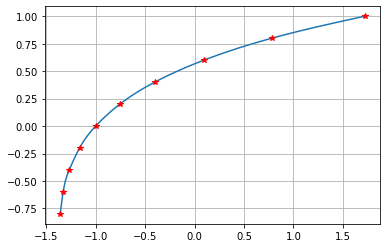

In [4]:
args = []
gvalues = []
for i in range(len(values)-1):
    l_args, l_values = get_intermediate_points(a[i], b[i], c[i], d[i], x[i], x[i+1], 20)
    args = args + l_args
    gvalues = gvalues + l_values
plt.plot(args, gvalues, '-')
plt.plot(data[0, :], data[1, :], 'r*')
plt.grid()
plt.show()

In [5]:
borders = []
der1 = []
der2 = []
for i in range(len(intervals)):
    tmp = a[i] - b[i]*intervals[i] + c[i]*(intervals[i]**2)/2 - d[i]*(intervals[i]**3)/6
    borders.append(tmp - values[i])
for i in range(1, len(intervals)):
    tmp = b[i] - c[i]*(intervals[i]) + d[i]*(intervals[i]**2)/2
    res = None
    res = tmp - b[i-1]
    der1.append(res)
for i in range(len(intervals)):
    tmp = c[i] - d[i]*intervals[i]
    res = None
    if i == 0:
        res = tmp
    else:
        res = tmp - c[i-1]
    der2.append(res)
print('максимальное расхождение значений в узлах: {}'.format(max(borders)))
print('максимальное расхождение значений производных в узлах: {}'.format(max(der1)))
print('максимальное расхождение значений 2 производных в узлах: {}'.format(max(der2)))

максимальное расхождение значений в узлах: 0.0
максимальное расхождение значений производных в узлах: 8.881784197001252e-16
максимальное расхождение значений 2 производных в узлах: 0.0


In [6]:
calculate(a[6], b[6], c[6], d[6], 0, data[0, 7])

0.5670340790525347